<a href="https://colab.research.google.com/github/geralm/Spatial_Transformer_Networks/blob/main/stnnotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Spatial transformer Networks with celebA dataset
Library importation

In [ ]:
#Install commet (tracking tool)
!pip install comet_ml

In [ ]:
import os
import time
import json
import torch
import zipfile
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils_data
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
from pathlib import Path
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model
from google.colab import drive
from google.colab import userdata #For cometml API KEY
#Google drive mount
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Settings

In [ ]:
CONFIG: dict = {
    "data": {
        "DRIVE_DATASET_PATH": "./drive/MyDrive/Spatial Transformer Networks/celeba/",
        "WORKING_DIR": "./DATASET",
        "ZIPNAME": "img_align_celeba.zip",
        "LIST_ATTR_FILE": "list_attr_celeba.txt",
        "LIST_PARTITION_FILE":"list_eval_partition.txt" ,
        "NUM_WORKERS": 4,
        "IMG_SIZE": 128 ,
        "BATCH_SIZE":64,
    },
    "model":{
        "NAME": "STN V1",
        "RANDOM_SEED": 1,
        "LEARNING_RATE": 0.001,
        "NUM_EPOCHS": 30 ,
        "NUM_FEATURES": 128,
        "CHANNELS":3,
        "LAYERS": [3, 4, 23, 3],
        "OPTIMIZER": "SGD", # OR ADAM,
        "LOSS_FUNCTION": "CrossEntropyLoss" # OR
    },
    "comet_tool": {
        "project_name": "spatialtransformernetworks",
        "workspace": "geralm"
    }
}
# CONCATENATE PATHS for drive
CONFIG["data"]["ZIPNAME"] = os.path.join(CONFIG["data"]["DRIVE_DATASET_PATH"], CONFIG["data"]["ZIPNAME"])
CONFIG["data"]["LIST_ATTR_FILE"] = os.path.join(CONFIG["data"]["DRIVE_DATASET_PATH"], CONFIG["data"]["LIST_ATTR_FILE"])
CONFIG["data"]["LIST_PARTITION_FILE"] = os.path.join(CONFIG["data"]["DRIVE_DATASET_PATH"], CONFIG["data"]["LIST_PARTITION_FILE"] )
# CONCATENATE PATHS FOR CURRENT DIRECTORY
CONFIG["data"]["IMG_DIR"]= os.path.join(CONFIG["data"]["WORKING_DIR"], CONFIG["data"].get("IMG_DIR",  "img_align_celeba/") )
CONFIG["data"]["TRAIN_FILE"] = os.path.join(CONFIG["data"].get("WORKING_DIR", ".celeba"), CONFIG["data"].get("TRAIN_FILE", "celeba-gender-train.csv"))
CONFIG["data"]["VAL_FILE"] = os.path.join(CONFIG["data"].get("WORKING_DIR"),  CONFIG["data"].get("VAL_FILE", "celeba-gender-valid.csv"))
CONFIG["data"]["TEST_FILE"] = os.path.join(CONFIG["data"].get("WORKING_DIR"), CONFIG["data"].get("TEST_FILE", "celeba-gender-test.csv"))
CONFIG["data"]["DATA_GENDER_FILE"] = os.path.join(CONFIG["data"]["WORKING_DIR"], CONFIG["data"].get("DATA_GENDER_FILE", "celeba-gender-partitions.csv"))
CONFIG["model"]["SAVE_MODEL_PATH"] = os.path.join(CONFIG["data"]["DRIVE_DATASET_PATH"], CONFIG["model"].get("NAME","stnmodel.pth"))
if CONFIG["model"]["NAME"].endswith(".pth"):
      CONFIG["model"]["SAVE_MODEL_PATH"] = os.path.join(CONFIG["data"]["DRIVE_DATASET_PATH"], CONFIG["model"]["NAME"])
else:
      CONFIG["model"]["SAVE_MODEL_PATH"] = os.path.join(CONFIG["data"]["DRIVE_DATASET_PATH"], CONFIG["model"]["NAME"] + ".pth")
print(CONFIG)

{'data': {'DRIVE_DATASET_PATH': './drive/MyDrive/Spatial Transformer Networks/celeba/', 'WORKING_DIR': './DATASET', 'ZIPNAME': './drive/MyDrive/Spatial Transformer Networks/celeba/img_align_celeba.zip', 'LIST_ATTR_FILE': './drive/MyDrive/Spatial Transformer Networks/celeba/list_attr_celeba.txt', 'LIST_PARTITION_FILE': './drive/MyDrive/Spatial Transformer Networks/celeba/list_eval_partition.txt', 'NUM_WORKERS': 4, 'IMG_SIZE': 128, 'BATCH_SIZE': 64, 'IMG_DIR': './DATASET/img_align_celeba/', 'TRAIN_FILE': './DATASET/celeba-gender-train.csv', 'VAL_FILE': './DATASET/celeba-gender-valid.csv', 'TEST_FILE': './DATASET/celeba-gender-test.csv', 'DATA_GENDER_FILE': './DATASET/celeba-gender-partitions.csv'}, 'model': {'NAME': 'STN V1', 'RANDOM_SEED': 1, 'LEARNING_RATE': 0.001, 'NUM_EPOCHS': 30, 'NUM_FEATURES': 128, 'CHANNELS': 3, 'LAYERS': [3, 4, 23, 3], 'OPTIMIZER': 'SGD', 'LOSS_FUNCTION': 'CrossEntropyLoss', 'SAVE_MODEL_PATH': './drive/MyDrive/Spatial Transformer Networks/celeba/STN V1.pth'}, 'c

## Initialize Comet experiment
Comet ML is a platform to track, compare, explain, and optimize machine learning models and experiments.

> **Note:** if you don't hace commet project, you can skit the next cell

In [ ]:
#Use comet if we have api key, project name, and experiment
#
experiment = Experiment(
  api_key=userdata.get('COMET_API_KEY'),
  project_name=CONFIG["comet_tool"]["project_name"],
  workspace=CONFIG["comet_tool"]["workspace"],
  auto_histogram_weight_logging=True,
  auto_histogram_gradient_logging=True,
  auto_histogram_activation_logging=True,
)
hyper_params = {
   "learning_rate": CONFIG["model"]["LEARNING_RATE"],
   "batch_size":  CONFIG["data"]["BATCH_SIZE"],
   "num_epochs":  CONFIG["model"]["NUM_EPOCHS"],
   "num_features":  CONFIG["model"]["NUM_FEATURES"],
   "loss_function" : CONFIG["model"]["LOSS_FUNCTION"],
   "optimizer" :CONFIG["model"]["OPTIMIZER"]
}
experiment.log_parameters(hyper_params)



COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : explicit_wheat_3308
COMET INFO:     url                   : https://www.comet.com/geralm/spatialtransformernetworks/66793410bc124cac941d1ef7247060fa
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 64
COMET INFO:     learning_rate : 0.001
COMET INFO:     loss_function : CrossEntropyLoss
COMET INFO:     num_epochs    : 5
COMET INFO:     num_features  : 128
COMET INFO:     optimizer     : SGD
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET 

---
## Preprocessing
If the WORKING_DIR doesn't exist, creates a new one
Takes the list_attributes and list_partitions files and build a csv with the data in the WORKING_DIR

In [ ]:

def extract_data(zip_path):
    """
    Call this function to extract Celeba
    Params:
    """
    zip_path = Path(zip_path)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(CONFIG["data"]["WORKING_DIR"])
def read_attributes(path:str):
    """
    Read the attributes from the file attr.txt
    """
    df = pd.read_csv(path, sep="\s+", skiprows=1, usecols=['Male'])
    # Make 0 (female) & 1 (male) labels instead of -1 & 1
    df.loc[df['Male'] == -1, 'Male'] = 0
    return df
def read_partition(path:str):
    """
    Read the partition from the file eval_partition.txt
    """
    df = pd.read_csv(path, sep="\s+", skiprows=0, header=None)
    df.columns = ['Filename', 'Partition']
    df = df.set_index('Filename')
    return df
def split(to_csv_path:str,
          train_csv,
          valid_csv,
          test_csv ,
          df1, df2):
    """
    Split the data into train, validation and test
    """
    df3 = df1.merge(df2, left_index=True, right_index=True)
    df3.to_csv(to_csv_path)
    df4 = pd.read_csv(to_csv_path, index_col=0)
    df4.loc[df4['Partition'] == 0].to_csv(train_csv)
    df4.loc[df4['Partition'] == 1].to_csv(valid_csv)
    df4.loc[df4['Partition'] == 2].to_csv(test_csv)
    return df4

class CelebaDataset(utils_data.Dataset):
    """Custom Dataset for loading CelebA face images"""
    def __init__(self, csv_path, img_dir, transform=None):
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        if self.transform is not None:
            img = self.transform(img)
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]
def show_image(path:str)->None:
        """
        Show an image
        """
        try:
            img = Image.open(path)
            print(np.asarray(img, dtype=np.uint8).shape)
            plt.imshow(img)
            plt.show()
        except:
            print("Could not open the image")
            return -1
        return 0
class Data_Loader(utils_data.DataLoader):
    def __init__(self, settings:dict):
        self.train_file = settings["data"]["TRAIN_FILE"]
        self.val_file = settings["data"]["VAL_FILE"]
        self.test_file = settings["data"]["TEST_FILE"]
        self.img_dir = settings["data"]["IMG_DIR"]
        self.batch = settings["data"]["BATCH_SIZE"]
        self.num_workers = settings["data"]["NUM_WORKERS"]
        self.img_size = settings["data"]["IMG_SIZE"]
        self.custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((self.img_size, self.img_size)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.5, 0.5, 0.5))])
        # Note that transforms.ToTensor()
        # already divides pixels by 255. internally

    def _train_dataset(self):
        return CelebaDataset(csv_path=self.train_file,
                              img_dir=self.img_dir,
                              transform=self.custom_transform)
    def _valid_dataset(self):
        return CelebaDataset(csv_path= self.val_file,
                              img_dir=self.img_dir,
                              transform=self.custom_transform)
    def _test_dataset(self):
        return CelebaDataset(csv_path= self.test_file,
                             img_dir=self.img_dir,
                             transform=self.custom_transform)
    def train_loader(self):
        return utils_data.DataLoader(dataset=self._train_dataset(),
                                     batch_size=self.batch,
                                     shuffle=True,
                                     num_workers=self.num_workers)
    def valid_loader(self):
        return utils_data.DataLoader(dataset=self._valid_dataset(),
                                     batch_size=self.batch,
                                     shuffle=False,
                                     num_workers=self.num_workers)
    def test_loader(self):
        return utils_data.DataLoader(dataset=self._test_dataset(),
                                     batch_size=self.batch,
                                     shuffle=False,
                                     num_workers=self.num_workers)


def preprocess(config):
    """
    This function runs the preprocessing steps
    1) Extract the data
    2) Read the attributes
    3) Read the partition
    4) Split the data
    5) Save the dataframes to a CSV file
    """

    img_align_dir  = os.path.join(config["data"]["WORKING_DIR"],  "img_align_celeba/")
    print("1) Extract the data")
    # if already extract the files
    if os.path.isdir(img_align_dir):
        print(f"\t{img_align_dir} directory exist")
    else:
        print(f"\tDid not find {img_align_dir} directory, creating one...")
        print("\tUnzipping Celeba dataset...")
        extract_data(config["data"]["ZIPNAME"])
        print(f"\t{config['data']['ZIPNAME']} extracted to {img_align_dir}")
    # Read the attributes

    print("2) Read the attributes")
    datacsv = config["data"]["DATA_GENDER_FILE"]
    if os.path.exists(datacsv):
        print(f"\t{datacsv} exist")
    else:
        print(f"\t{datacsv} does not exist, creating one...")
        train_path =  config['data']['TRAIN_FILE']
        test_path = config['data']['TEST_FILE']
        val_path = config['data']['VAL_FILE']
        print("3) Read the attributes")
        df1 = read_attributes( config['data']['LIST_ATTR_FILE'])
        print("4) Read partitions")
        df2 = read_partition( config['data']['LIST_PARTITION_FILE'])
        print("5) Save data")
        df3 = split(datacsv, train_path, val_path, test_path, df1, df2)
        print(f"\tDataframes saved")
    # Read the partition

    # Split the data
    print("Finished preprocessing")

  # Run the preprocessing

preprocess(CONFIG)

1) Extract the data
	./DATASET/img_align_celeba/ directory exist
2) Read the attributes
	./DATASET/celeba-gender-partitions.csv exist
Finished preprocessing


---
### CLASES

### Training class
Training functions in a class

In [ ]:
class Trainer():
    def __init__(self, train_loader, validation_loader, model, device, settings) -> None:
        self._SEED = settings["model"]["RANDOM_SEED"]
        torch.manual_seed(self._SEED)
        self._LEARNING_RATE = settings["model"]["LEARNING_RATE"]
        self._NUM_EPOCHS =  settings["model"]["NUM_EPOCHS"]
        self._DEVICE = device

        self.train_loader = train_loader
        self.validation_loader = validation_loader

        self.model = model
        if settings["model"]["OPTIMIZER"] == "SGD":
          self.optimizer = torch.optim.SGD(model.parameters(), lr=self._LEARNING_RATE)
        elif settings["model"]["OPTIMIZER"] == "ADAM":
          self.optimizer =torch.optim.Adam(model.parameters(), lr=self._LEARNING_RATE)
        else: #SGD BY DEFAULT
          self.optimizer = torch.optim.SGD(model.parameters(), lr=self._LEARNING_RATE)


    def _trainfunc(self, epoch):
        self.model.train()
        cost_fn = torch.nn.CrossEntropyLoss()
        for batch_idx, (features,targets) in enumerate(self.train_loader):
            features, targets = features.to(self._DEVICE), targets.to(self._DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = self.model(features)
            cost = cost_fn(logits, targets)
            self.optimizer.zero_grad()
            cost.backward()
            ### UPDATE MODEL PARAMETERS
            self.optimizer.step()
            ### LOGGING
            if not batch_idx % 50:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                    %(epoch+1,self._NUM_EPOCHS , batch_idx,
                        len(self.train_loader), cost))
    def run(self):
        start_time = time.time()
        for epoch in range(self._NUM_EPOCHS):
            self._trainfunc(epoch)
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

        return self.model


### Test class
Test functions in a class

In [ ]:
class Tester():
    def __init__(self, test_loader, model, device) -> None:
        self.model = model
        self.device = device
        self.test_loader = test_loader
    def _convert_image_np(self, inp):
        """Convert the image to np."""
        inp = inp.numpy().transpose((1, 2, 0))
        mean_rgb = np.array([0.5, 0.5, 0.5])
        std_rgb = np.array([0.5, 0.5, 0.5])
        inp = std_rgb * inp + mean_rgb
        inp = np.clip(inp, 0, 1)
        return inp
    def visualize_stn(self, save_path='stn_visualization.png'):
        self.model.eval()
        plt.ion()
        with torch.no_grad():
        # Get a batch of training data
            data = next(iter(self.test_loader))[0].to(self.device)

            input_tensor = data.cpu()
            transformed_input_tensor = self.model.stn(data).cpu()

            in_grid = self._convert_image_np(
                torchvision.utils.make_grid(input_tensor))

            out_grid = self._convert_image_np(
                torchvision.utils.make_grid(transformed_input_tensor))

            # Plot the results side-by-side
            f, axarr = plt.subplots(1, 2)
            axarr[0].imshow(in_grid)
            axarr[0].set_title('Dataset Images')

            axarr[1].imshow(out_grid)
            axarr[1].set_title('Transformed Images')
        plt.ioff()
        plt.show()
        f.savefig(save_path)


### Model / Spatial transformer network\
The model, you can modify the net arquitecture here

In [ ]:
class STN(nn.Module):
    def __init__(self, channels, img_size):
        super(STN, self).__init__()
        in_dim = channels
        self._imsize = img_size
        self.fc2 = nn.Linear(3*self._imsize*self._imsize, 2)
        conv_dim = 128
        self.localization = nn.Sequential(
            nn.Conv2d(in_dim, conv_dim, kernel_size=11, stride=2, padding=3),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            #layer 1 64
            nn.Conv2d(conv_dim, conv_dim*2, kernel_size=7),
            nn.ReLU(True),
             #layer 1 64
            nn.Conv2d(conv_dim*2, conv_dim*4, kernel_size=3 ),
            nn.ReLU(True),

            nn.Conv2d(conv_dim*4, conv_dim*4, kernel_size=2),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            )

        self.fc_loc = nn.Sequential(
                                    nn.Linear(512*11*11, 512),
                                    nn.ReLU(True),
                                    nn.Linear(512 , 2*3)
                                    )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[-1].weight.data.zero_()
        self.fc_loc[-1].bias.data.copy_(
            torch.tensor([1, 0, 0, 0, 1, 0] , dtype=torch.float)
            )
    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1,  512*11*11)
        # xs = F.normalize(xs, dim=-1)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3) # Theta size [N x 2 x 3]

        grid = F.affine_grid(theta, x.size())
        #,mode="bilinear", padding_mode="border",
        x = F.grid_sample(x, grid)
        return x
    def forward(self, x):
        x = self.stn(x)
        x = x.view(-1, 3*self._imsize*self._imsize)
        logits  = self.fc2(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas
def build_model(config:dict):
    channels = config["model"]["CHANNELS"]
    img_size = config["data"]["IMG_SIZE"]
    return STN(channels, img_size=img_size)

---
# RUN EXPERIMENT


In [ ]:
data_loader = Data_Loader(CONFIG)
train_loader = data_loader.train_loader()
valid_loader = data_loader.valid_loader()
test_loader = data_loader.test_loader()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#build model
model = build_model(CONFIG).to(device)

trainer  = Trainer(
        train_loader=train_loader,
        validation_loader=valid_loader,
        model=model,
        device=device,
        settings=CONFIG
        )
tester = Tester(
            test_loader=test_loader,
            model=model,
            device=device
        )



Training the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4404: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch: 001/030 | Batch 0000/2544 | Cost: 0.7859
Epoch: 001/030 | Batch 0050/2544 | Cost: 0.5058
Epoch: 001/030 | Batch 0100/2544 | Cost: 0.4916
Epoch: 001/030 | Batch 0150/2544 | Cost: 0.3384
Epoch: 001/030 | Batch 0200/2544 | Cost: 0.4296
Epoch: 001/030 | Batch 0250/2544 | Cost: 0.3266
Epoch: 001/030 | Batch 0300/2544 | Cost: 0.2909
Epoch: 001/030 | Batch 0350/2544 | Cost: 0.3323
Epoch: 001/030 | Batch 0400/2544 | Cost: 0.2215
Epoch: 001/030 | Batch 0450/2544 | Cost: 0.3512
Epoch: 001/030 | Batch 0500/2544 | Cost: 0.3317
Epoch: 001/030 | Batch 0550/2544 | Cost: 0.2699
Epoch: 001/030 | Batch 0600/2544 | Cost: 0.2517
Epoch: 001/030 | Batch 0650/2544 | Cost: 0.2458
Epoch: 001/030 | Batch 0700/2544 | Cost: 0.3325
Epoch: 001/030 | Batch 0750/2544 | Cost: 0.2091
Epoch: 001/030 | Batch 0800/2544 | Cost: 0.2445
Epoch: 001/030 | Batch 0850/2544 | Cost: 0.5047
Epoch: 001/030 | Batch 0900/2544 | Cost: 0.3612
Epoch: 001/030 | Batch 0950/2544 | Cost: 0.2458
Epoch: 001/030 | Batch 1000/2544 | Cost:

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 002/030 | Batch 0000/2544 | Cost: 0.1895
Epoch: 002/030 | Batch 0050/2544 | Cost: 0.1120
Epoch: 002/030 | Batch 0100/2544 | Cost: 0.2495
Epoch: 002/030 | Batch 0150/2544 | Cost: 0.1642
Epoch: 002/030 | Batch 0200/2544 | Cost: 0.3298
Epoch: 002/030 | Batch 0250/2544 | Cost: 0.1743
Epoch: 002/030 | Batch 0300/2544 | Cost: 0.2669
Epoch: 002/030 | Batch 0350/2544 | Cost: 0.1735
Epoch: 002/030 | Batch 0400/2544 | Cost: 0.1701
Epoch: 002/030 | Batch 0450/2544 | Cost: 0.2453
Epoch: 002/030 | Batch 0500/2544 | Cost: 0.3279
Epoch: 002/030 | Batch 0550/2544 | Cost: 0.1696
Epoch: 002/030 | Batch 0600/2544 | Cost: 0.1860
Epoch: 002/030 | Batch 0650/2544 | Cost: 0.2085
Epoch: 002/030 | Batch 0700/2544 | Cost: 0.1852
Epoch: 002/030 | Batch 0750/2544 | Cost: 0.1682
Epoch: 002/030 | Batch 0800/2544 | Cost: 0.2971
Epoch: 002/030 | Batch 0850/2544 | Cost: 0.2204
Epoch: 002/030 | Batch 0900/2544 | Cost: 0.2667
Epoch: 002/030 | Batch 0950/2544 | Cost: 0.1801
Epoch: 002/030 | Batch 1000/2544 | Cost:

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : extreme_mantel_5277
COMET INFO:     url                   : https://www.comet.com/geralm/spatialtransformernetworks/c1efe8782aaa41bf99e740d3cdc4f027
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 64
COMET INFO:     learning_rate : 0.001
COMET INFO:     loss_function : CrossEntropyLoss
COMET INFO:     num_epochs    : 30
COMET INFO:     num_features  : 128
COMET INFO:     optimizer     : SGD
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 2 (136.20 MB)
COMET INFO:     notebook            : 2
COMET INFO:     os 

Model saved!


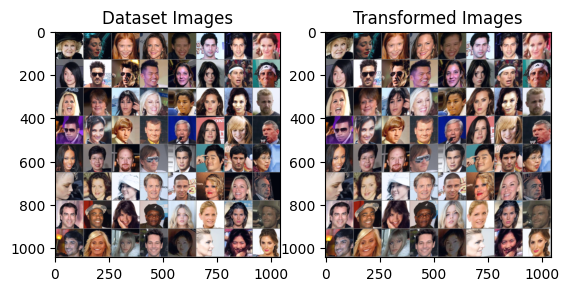

In [ ]:
print("Training the model...")
model = trainer.run()
if experiment is not None:
  log_model(experiment, model=model, model_name= CONFIG["model"]["NAME"])
  experiment.end()

torch.save(model.state_dict(), CONFIG["model"]["SAVE_MODEL_PATH"])
print("Model saved!")
imgToSave = CONFIG["model"]["SAVE_MODEL_PATH"].replace(".pth", ".png")
tester.visualize_stn(imgToSave)
print("Img saved!")
print("Everything finished!")
